# Advanced Lane Finding
### Objectives:

1. compute camera calibration to correct for distortion in input images
2. apply color masking to input image to identify lane lines 
3. create birds-eye-view of road
4. identify lane pixels and compute confidence window
5. fit polynomial to confidence window
6. calculate turn-curvature & vehicle position on road
7. return appended video

In [221]:
import os, glob
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import deque

plt.rcParams['figure.figsize'] = [15,15]
plt.rcParams['image.cmap'] = 'gray'

In [222]:
def compare_pictures(img1, img2, title1, title2):
    fig = plt.figure(figsize=(15,15))
    fig.add_subplot(1, 2, 1, title=title1)
    plt.imshow(img1)
    fig.add_subplot(1, 2, 2, title=title2)
    plt.imshow(img2)
    plt.show()
plt.show()

## 1. Camera Calibration

Camera Calibration function takes a list of chessboard images to identify and draw the chessboard corners if found.

In [223]:
def camera_calibration(images, nx,ny):
    
    subpix = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    objpoints = [] 
    imgpoints = [] 
    images_with_corners = []
    counter = 0    
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for image in images:
        img = mpimg.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if ret == True:
            counter += 1
            corners = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),subpix)
            imgpoints.append(corners); objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            images_with_corners.append(img)   
    print(f'{counter}/{len(images)} corners found')
    return objpoints, imgpoints, images_with_corners

From the returned imagepoints and objectpoints a distortion matrix can be computed and applied to the picture

In [224]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

17/20 corners found


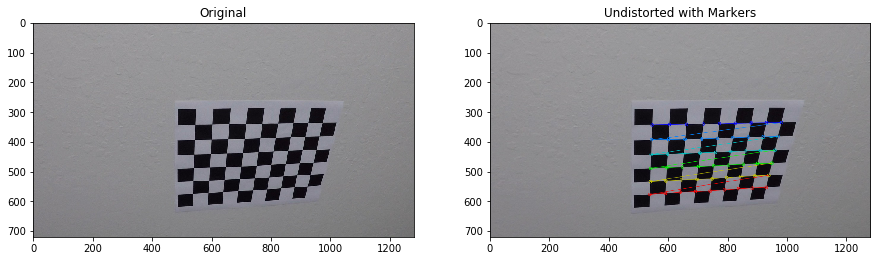

In [225]:
objpoints, imgpoints, images = camera_calibration(glob.glob('camera_cal/*jpg'), 9, 6)

chess_org = mpimg.imread(glob.glob('camera_cal/*jpg')[1])
chess_dist  = cal_undistort(images[0], objpoints, imgpoints)

compare_pictures(
    chess_org, 
    chess_dist, 'Original', 'Undistorted with Markers')

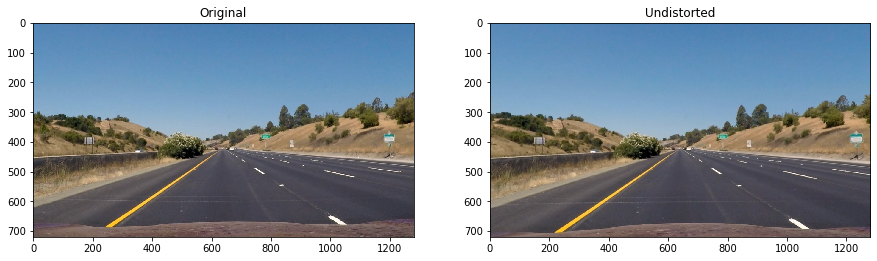

In [226]:
img = mpimg.imread(glob.glob('test_images/*jpg')[0])
img_undist = cal_undistort(img, objpoints, imgpoints)
compare_pictures(
    img, 
    img_undist, 'Original', 'Undistorted')

## 2. Color Masking

The input image is converted into HSV Format to apply some filtering to the image.

The filtering includes a saturation filter on the S channel, which only takes the top 5% of saturated pixels (nanquantile). This way, sudden changes of brightness will not effect the quality of the outcome to much and the line is still clearly visible. As a second filtering, white and yellow colors are filtered out with the given channel information. Both masks are then applied with the or statement, to create the binary image for further processing.

In [227]:
img_copy = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HSV)

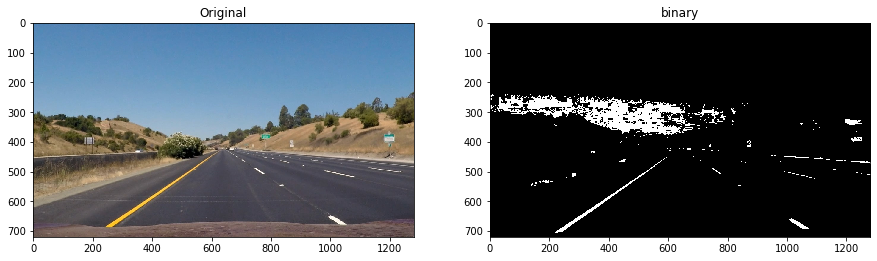

In [228]:
def get_binary(img):
    
    # Saturation Filters
    S = img[:,:,2]
    #thresh = (np.nanquantile(S, 0.95),255)

    # numpy version is outdated, therefore workaround
    sorted_s = sorted(S.reshape(-1))
    quantile = int(len(sorted_s) * 0.95)
    thresh = (float(sorted_s[quantile]), 255)
    s_mask = cv2.inRange(S, thresh[0], thresh[1])
    
    # Color Filters
    low_white = np.array([0, 0, 225], dtype=np.uint8)
    high_white = np.array([90,70,255], dtype=np.uint8)
    low_yellow = np.array([14,120,220], dtype=np.uint8)
    high_yellow = np.array([30,255,255], dtype=np.uint8)

    white_mask = cv2.inRange(img, low_white, high_white)
    yellow_mask = cv2.inRange(img, low_yellow, high_yellow)
    
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    
    binary = cv2.bitwise_or(color_mask, s_mask)
    
    return binary

binary = get_binary(img_copy)

compare_pictures(
    img, 
    binary, 'Original', 'binary')

## 3. Birds-eye-view

The goal of creating a birds-eye-view is converting the image so that the lanes are as parallel as possible. Therefore an isosceles trapezoid is streched from fixed coordinates with the warp_perspective function. This function will also compress our image back to normal if source and destination are swapped out. 

In [229]:
def warp_perspective(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped_image = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_image

In [230]:
src = np.float32(
[[150,720], # bottom left
 [1130, 720], # bottom right
 [500,460], # top left
 [740, 460]]) # top right

dst = np.float32(
[[380,720],
 [900, 720],
 [150,0],
 [1080, 0]])

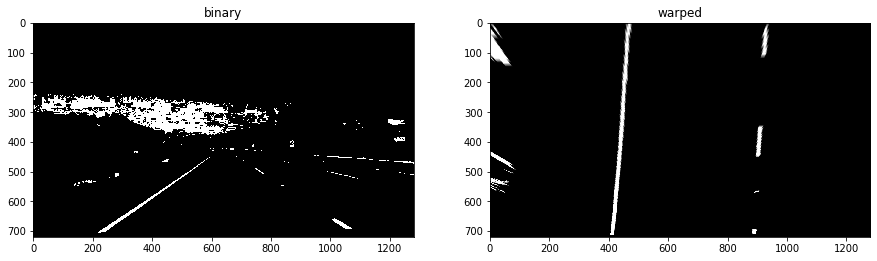

In [231]:
binary_warped = warp_perspective(binary, src, dst)
compare_pictures(
    binary, 
    binary_warped, 'binary', 'warped')

## 4. Lane Pixels

When we start looking for lane pixels an either side its best to start from the bottom, since the top will be stretched the most and therefore fuzzy. In general we want to cut the image into smaller slices and search for the x-Value with the highest sum of pixels on both sides. We pass the image and the coordinates of the slice from the y-axis. 

In [232]:
def get_base_nonlinear(binary_warped, y_coords):
    
    start = y_coords[0]
    end = y_coords[1]   
    
    mid_x = int(binary_warped.shape[1] / 2)
    left_base = np.argmax(np.sum(binary_warped[start:end,:mid_x],axis=0))
    right_base = np.argmax(np.sum(binary_warped[start:end,mid_x:],axis=0)) + mid_x

    return left_base, right_base

If we have successfully made a detection we can use the information of the last frame for the next. If it's the first detection, we won't have any information on the previous lane. 

Here I keep track of the change of the delta.  If the Delta in x for two following frames is so high, that it is unlikely a correct observation I copy the moving delta from the other lane (if detected) to get an approximate frame for the missing lane (e.g. when dotted). 

If both lanes are failed to detect, the last observation gets copied.

In [233]:
def correct_base(left_base, right_base, last_window, window_size=75):
    
    if last_window[0] != None:
        last_left = last_window[0]
        last_right = last_window[1]
        delta_left = last_left - left_base
        delta_right = last_right - right_base
        right_found = True
        left_found = True

        # if proximity between the new and old window is not given then we assume we have trouble identifying it
        if abs(delta_left) > window_size:
            left_found = False

        if abs(delta_right) > window_size:
            right_found = False

        # if one lane is found, dubplicate the shift on the other lane
        if left_found and not right_found:
            right_base = last_right - delta_left
        elif right_found and not left_found:
            left_base = last_left - delta_right
        # if none are found take last observation
        elif not left_found and not right_found:
            right_base = last_right
            left_base = last_left
            
    return left_base, right_base

With the base finding and correction we can now implement the function to create confidence windows in the plot. The function accepts the binary_warped image and given y_coordinates and returns the x,y coordinates for the confidence rectangle around the centers of the left and right lane. 

In [234]:
def create_window_nonlinear(binary_warped, y_coords, last_window, window_size = 75, threshold = 10):
    
    start = y_coords[0]
    end = y_coords[1]
    
    left_base, right_base = get_base_nonlinear(binary_warped, [start, end])
    left_base, right_base = correct_base(left_base, right_base, last_window)
    
    start_x_left, end_x_left = left_base - window_size, left_base + window_size
    start_x_right, end_x_right = right_base - window_size, right_base + window_size 
    
    pts_left = [(start_x_left, start), (end_x_left, end)]
    pts_right = [(start_x_right, start), (end_x_right, end)]
    
    return pts_left, pts_right, left_base, right_base, int(np.mean(y_coords))

To iterate through the complete image we initialize the current bases with None so the first observation will not get corrected. First I started with a fixed window size for the base finding function, but noticed that it failed to detect the lane in cases where dotted lanes lead to errors finding the base. Therefore I start with a bigger window (20% of img) and decrease the size every window by 30% to a minimum of 60 pixels. This leads to a small error on the bottom of the screen but increases the quality for pixels further down the road. 

A rectangle with the returned coords will be drawn in an empty image. Additionally we initialize lists to track the x and y position we will calculate a polyfit later on.  

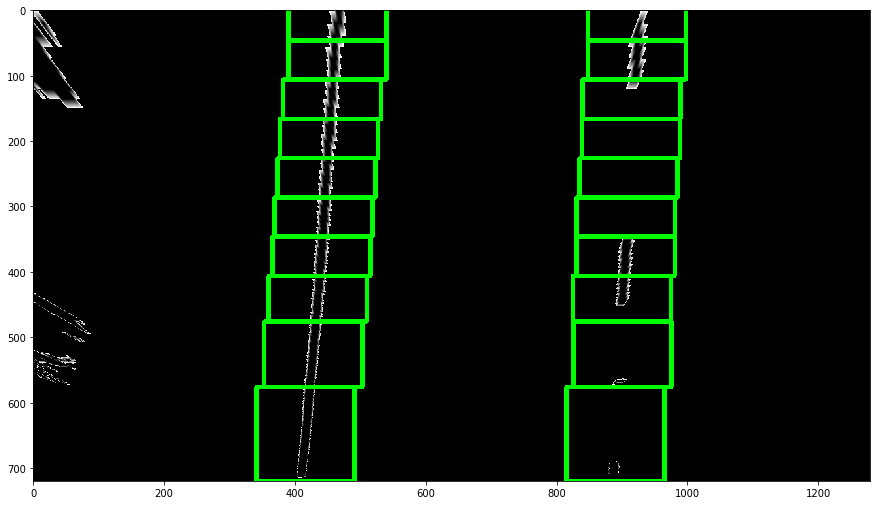

In [235]:
def get_poly_bases_nonlinear(binary_warped):
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    left_base = None
    right_base = None
    
    last_left_base = None
    last_right_base = None

    left_i = []
    right_i = []
    y_vals = []

    start = binary_warped.shape[0]
    smaller_each_step = 0.7
    smallest_size = 60
    size = int(start / 5)
    
    while start > 0:
        
        start_y = start
        end_y = start_y - size
        
        last_left_base = left_base
        last_right_base = right_base

        pts_left, pts_right, left_base, right_base, y_val = create_window_nonlinear(
            binary_warped,
            [end_y, start_y],
            [left_base, right_base])
        
        cv2.rectangle(out_img,pts_left[0],
                pts_left[1],(0,255,0), 5) 
        cv2.rectangle(out_img,pts_right[0],
                pts_right[1],(0,255,0), 5)

        left_i.append(left_base); right_i.append(right_base); y_vals.append(y_val)
        
        start = end_y
        size = int(size * smaller_each_step)
        if size < smallest_size:
            size = smallest_size
        
    left_i = np.array(left_i)
    right_i = np.array(right_i)
    y_vals = np.array(y_vals)
    
    return left_i, right_i, y_vals, out_img

l,r,y, i = get_poly_bases_nonlinear(binary_warped)
plt.imshow(i);

Since the calculated bases serve as the input for calculating the polynomial, we want to smooth the lane by avaraging the difference of the base with the last observation of the base. If the base is not within a confidence window of 70 pixels, the last known base will be taken. This way single wrong frame calculations do not effect the overall quality as much. Therefore we create global deque list, were the last observation will be stored after calculation.

In [236]:
OBS_LEN = 1
obs_l = deque(maxlen=OBS_LEN)
obs_r = deque(maxlen=OBS_LEN)

def compare_bases(base_new, base_old):
    
    out = np.zeros_like(base_new)
    for i in range(0, len(base_new)):  

        if (base_old[0][i] - 70) < base_new[i] < (base_old[0][i] + 70):
            out[i] = np.mean([base_new[i], base_old[0][i]])
        else:
            out[i] = base_old[0][i]
    return out

With the 3 arrays with all the information (x,y) about the lanes, we fit a polynomial to the gathered points and plot it with an area on an empty frame. The function returns the image with drawn lanes, the polynomial fits for both lanes and the image with confidence intervals.

In [237]:
def draw_poly(binary_warped):
    
    global obs_l, obs_r
    
    out_lanes = np.zeros_like(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    
    left_i, right_i, y_vals, intervals = get_poly_bases_nonlinear(binary_warped)
    
    if len(obs_l) != 0:
        left_i, right_i = compare_bases(left_i, obs_l), compare_bases(right_i, obs_r)
    obs_l.append(left_i); obs_r.append(right_i)
    
    left_fit = np.polyfit(y_vals, left_i, 2)
    right_fit = np.polyfit(y_vals, right_i, 2)
    
    ploty = np.linspace(50, binary_warped.shape[0]-1, binary_warped.shape[0])
        
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Plots the left and right polynomials on the lane lines
    left_lane = np.vstack((left_fitx, ploty)).T.astype(np.int32)
    right_lane = np.vstack((right_fitx, ploty)).T.astype(np.int32)
    area = np.concatenate((left_lane, right_lane[::-1]))

    cv2.polylines(out_lanes, [left_lane], isClosed=False, color=(141,2,31), thickness=60)
    cv2.polylines(out_lanes, [right_lane], isClosed=False, color=(141,2,31), thickness=60)
    cv2.fillConvexPoly(out_lanes, area, color=(80,200,122))
    
    return out_lanes, left_fit, right_fit, left_lane, right_lane, intervals

Now we can outwarp the perspective and weight the two images within the plot. As can be seen, the identified area has a high proximity with the actual lane. Also the identified intervals will serve as verification and fallback for following frames. 

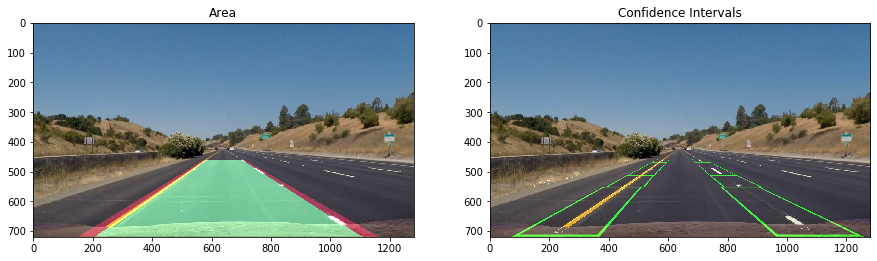

In [238]:
lanes, left_fit, right_fit, left_lane, right_lane, intervals = draw_poly(binary_warped)
lanes = warp_perspective(lanes, dst, src)
intervals = warp_perspective(intervals, dst, src)

final_img = cv2.addWeighted(img,0.9,lanes,.7,0)
interval_img = cv2.addWeighted(img,0.9,intervals,.7,0)

compare_pictures(
    final_img, 
    interval_img, 'Area', 'Confidence Intervals')

## 6. Turn-curvature & vehicle position on road

Next we want to calculate the radius of the current curve. We assume a lane width to be around 3 meters at the cars position at y = 720. Inspecting above picture shows that the lane takes around 900 pixels, therefore we can calculate the length of one pixel at this position is around 3 cm. With building an avaraging function for both lanes, we can calculate the approximate radius of the current curve.

In [239]:
CM_PER_VERTICAL_PIXEL = 1 / 3

left_curve = ((1 + (2*left_fit[0]*img.shape[0] + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curve = ((1 + (2*right_fit[0]*img.shape[0] + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

curve_radius = round((left_curve + right_curve) * CM_PER_VERTICAL_PIXEL,1)

For determining the position of the car on the road we check for the average center between the two lanes and track the delta to the actual image center in the middle of the x-axis. We check for the first 20 Pixels from bottom up und avarage the deltas to get the lane_dif for the upcoming road segment.

In [240]:
cm_per_pixel = 3.7 / 1000
image_center = int(img.shape[0] / 2)


lane_diffs = [((COORDS[0] + COORDS[1]) / 2 - image_center) * cm_per_pixel 
              for COORDS in zip(right_lane[::-1][:20].T[0], left_lane[::-1][:20].T[0])]
lane_dif = round(np.mean(lane_diffs), 2)

To display the information on the image we set up a standard text for both measures.

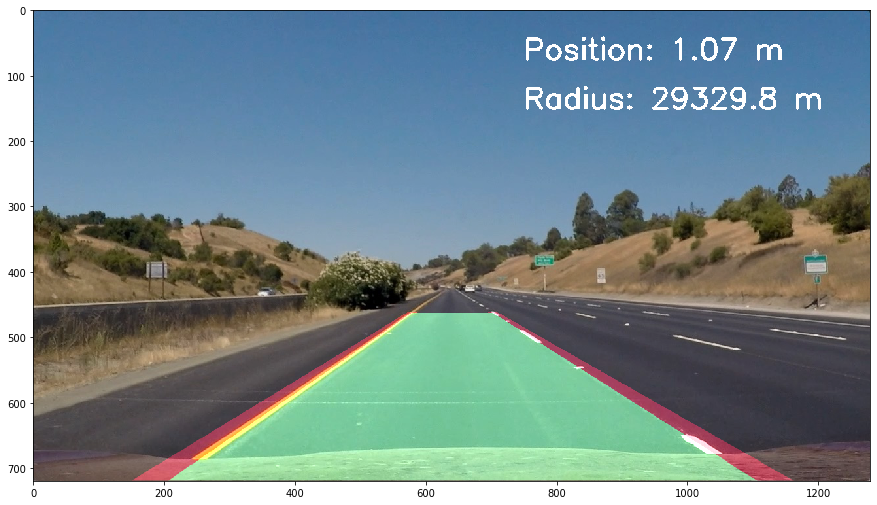

In [241]:
curv_text = f'Radius: {round(curve_radius,2)} m' if curve_radius > 10000 else f'Radius: {round(curve_radius / 1000,2)} km'
lane_text  = f'Position: {abs(lane_dif)} m'

cv2.putText(final_img, lane_text,(750, 75),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),4)
cv2.putText(final_img, curv_text,(750, 150),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),4)

plt.imshow(final_img);

The final output of the image has an appended lane and lane area, as well as the information of the position on the road and the curve radius of the current path. For video processing we include the calculations also as as function.

In [242]:
def get_curve_text(left_fit, right_fit, img):
    
    METERS_PER_VERTICAL_PIXEL = 30
    left_curve = ((1 + (2*left_fit[0]*img.shape[0] + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curve = ((1 + (2*right_fit[0]*img.shape[0] + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    curve_radius = round((left_curve + right_curve) * METERS_PER_VERTICAL_PIXEL,1)
    curve_text = f'Radius: {round(curve_radius/1000,2)} m'
    cv2.putText(img, curve_text,(750, 150),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),4)
    
    return img

def get_position_text(left_lane, right_lane, img):
    
    cm_per_pixel = 3.7 / 1000
    image_center = 1280 / 2

    lane_diffs = [((COORDS[0] + COORDS[1]) / 2 - image_center) * cm_per_pixel 
                  for COORDS in zip(right_lane[::-1][:20].T[0], left_lane[::-1][:20].T[0])]
    lane_dif = round(np.mean(lane_diffs), 3)
    
    lane_text =  f'Position: {abs(lane_dif)} m'
    cv2.putText(img, lane_text,(750, 75),cv2.FONT_HERSHEY_SIMPLEX,1.5,(255, 255, 255),4)
    
    return img

## Process Video 

Dealing with a stream of image data like in a camera means applying the above steps and returning an appended video. Steps included are:
1. the conversion into HSV Color
2. undistorting the image from the camera calibration
3. filtering color compontents to receive a binary picture
4. create birds-eye-view
5. fit polynomial to identified lane points
6. draw and distort the ploted image on the input
7. calculate curvature & position on road

In [243]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_vid = 'project_video.mp4'
output_vid = 'output_project_video.mp4'

In [244]:
def video_img_processing(img):
    
    img_copy = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_copy = cal_undistort(img_copy, objpoints, imgpoints)
    
    binary = get_binary(img_copy)
    binary_warped = warp_perspective(binary, src, dst)
    
    lanes, left_fit, right_fit, left_lane, right_lane, intervals = draw_poly(binary_warped)
    
    # displaying drawn lanes
    lanes = warp_perspective(lanes, dst, src)
    final_img = cv2.addWeighted(img,0.9,lanes,.7,0)
    
    # displaying confidence intervals
    #intervals = warp_perspective(intervals, dst, src)
    #final_img = cv2.addWeighted(img,0.9,intervals,.7,0)
    
    final_img = get_position_text(left_lane, right_lane, final_img)
    final_img = get_curve_text(left_fit, right_fit, final_img)

    return final_img

In [46]:
obs_l = deque(maxlen=OBS_LEN)
obs_r = deque(maxlen=OBS_LEN)

clip = VideoFileClip(input_vid)
clip_annotated = clip.fl_image(video_img_processing)
%time clip_annotated.write_videofile(output_vid, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



 24%|██▍       | 303/1261 [08:11<25:58,  1.63s/it]


 48%|████▊     | 605/1261 [16:32<18:16,  1.67s/it]


 72%|███████▏  | 907/1261 [24:50<09:34,  1.62s/it]


 96%|█████████▌| 1205/1261 [33:08<01:31,  1.63s/it]


100%|█████████▉| 1260/1261 [34:38<00:01,  1.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 31min 50s, sys: 16.2 s, total: 32min 7s
Wall time: 34min 41s


In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_vid))

## Weaknesses and shortcomings

Changing weather conditions like intense light or dark shadows will harm the quality of the binary image with lots of input. This can also be observed within the video around 25-30s where a sudden change in brightness disturbs the observation. 

Additionally the performance of the image processing is not quite as fast as the images come in. Expecting a 25fps Video, the programm will need 1s per frame on a good computer, therefore some steps that repeat and dont change over time could be avoided. Some ways to reduce processing may be working with deques for past oberservations and average those, so not every frame has to be evalued. Additionally one could apply some machine learning for correctly identifying lanes, which would also reduce the verification steps and heavy image processing. When comparing the computation time for each step, one can clearly see that the distortion correction is by far the heaviest calculation in the pipeline, so every performance improvement here will massively improve the speed of the programm. 

Process Time:
- Converting 0.01
- Undistorting 1.31
- Binary 1.63
- Warping 1.64
- Lane Finding 1.66
- Warping 1.67
- Calculations 1.67

In [40]:
import time

def video_img_processing_time(img):
    
    start_time = round(time.time(),2)
    img_copy = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    print('Converting', round(time.time() - start_time,2))
    img_copy = cal_undistort(img_copy, objpoints, imgpoints)
    print('Undistorting', round(time.time() - start_time,2))
    binary = get_binary(img_copy)
    print('Binary', round(time.time() - start_time,2))
    binary_warped = warp_perspective(binary, src, dst)
    print('Warping', round(time.time() - start_time,2))
    lanes, left_fit, right_fit, left_lane, right_lane, intervals = draw_poly(binary_warped)
    print('Lane Finding', round(time.time() - start_time,2))
    intervals = warp_perspective(intervals, dst, src)
    final_img = cv2.addWeighted(img,0.9,intervals,.7,0)
    print('Warping', round(time.time() - start_time,2))
    final_img = get_position_text(left_lane, right_lane, final_img)
    final_img = get_curve_text(left_fit, right_fit, final_img)
    print('Calculations', round(time.time() - start_time,2))
    print('__________')

    return final_img

In [42]:
obs_l = deque(maxlen=OBS_LEN)
obs_r = deque(maxlen=OBS_LEN)

clip = VideoFileClip(input_vid)
clip_annotated = clip.fl_image(video_img_processing_time).subclip(0,0.02)
%time clip_annotated.write_videofile('speedtest.mp4', audio=False)

Converting 0.01
Undistorting 1.31
Binary 1.63
Warping 1.64
Lane Finding 1.66
Warping 1.67
Calculations 1.67
__________
Converting 0.01
Undistorting 1.18
Binary 1.5
Warping 1.51
Lane Finding 1.52
Warping 1.54
Calculations 1.54
__________
[MoviePy] >>>> Building video project_video_altered.mp4
[MoviePy] Writing video project_video_altered.mp4



  0%|          | 0/1 [00:00<?, ?it/s]

Converting 0.02


Undistorting 1.21



100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

Binary 1.53
Warping 1.54
Lane Finding 1.56
Warping 1.57
Calculations 1.57
__________
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_altered.mp4 

CPU times: user 1.53 s, sys: 35.9 ms, total: 1.57 s
Wall time: 1.66 s
